In [2]:
import numpy as np
import pandas as pd
import cv2 as cv
import glob as gb
import os
import matplotlib.pyplot as plt

In [ ]:
peoples = ['Khald', 'M.Ashraf', 'Mohammad', 'Toto','elsoudy']
face_detection=cv.CascadeClassifier('cascades/data/haarcascade_frontalface_alt2.xml')
DIR=r'C:\Users\ELSOUDY\faces\Faces\train'
c_c=0
X_train=[]
y_train=[] 
p_p=0
for pe in peoples:
    path = os.path.join(DIR,pe)
    lab = peoples.index(pe)
    files=gb.glob(pathname=(path+'/*.jpg'))
    #label =os.path.basename(root).replace(' ','_').lower()
    for file in files:
        image = cv.imread(file)
        gray=cv.cvtColor(image,cv.COLOR_BGR2GRAY)
        face=face_detection.detectMultiScale(gray,1.4,4)
        p_p+=1
        for x,y,h,w in face:
            X_train.append(cv.resize(image[y:y+h,x:x+w],(60,60)))
            y_train.append(lab)
            c_c+=1
            
cv.destroyAllWindows()
print(p_p)
print(c_c)
recognizer=cv.face.LBPHFaceRecognizer_create()

In [5]:
recognizer=cv.face.LBPHFaceRecognizer_create()
#recognizer=cv2.face.LBPHFaceRecognizer_create()

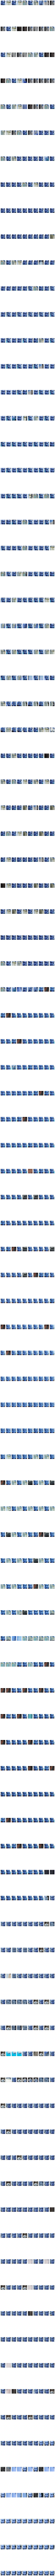

In [8]:
plt.figure(figsize=(10,500))
for i in range(1000) : 
    plt.subplot(100,10,i+1)
    plt.imshow(X_train[i])   
    plt.axis('off')

In [37]:
X_train=np.array(X_train)


In [38]:
y_train=np.array(y_train)
y_train.shape

(981,)

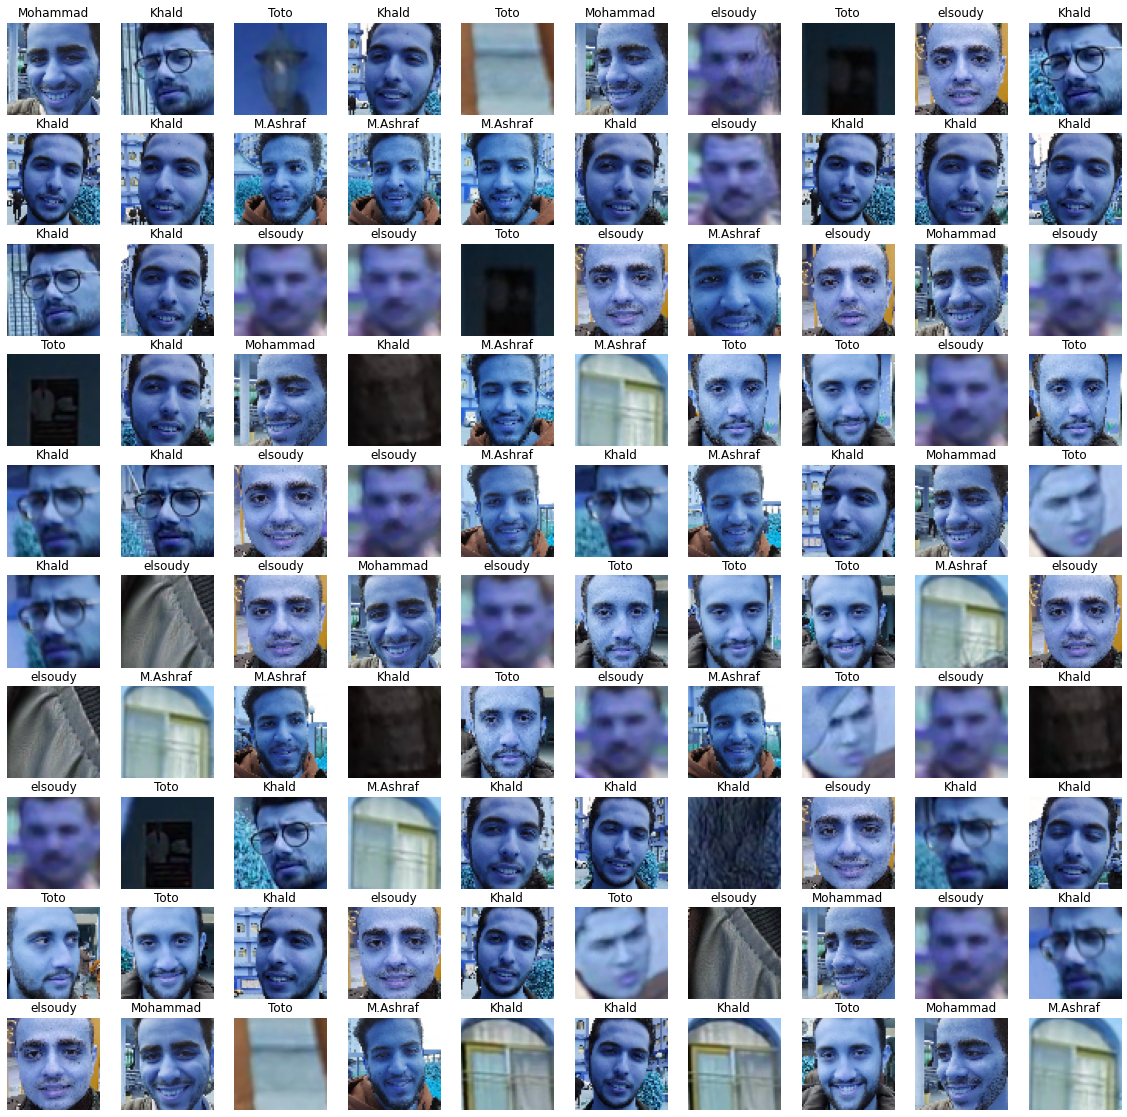

In [39]:
plt.figure(figsize=(20,20))
for n,i in enumerate(np.random.randint(0,len(X_train),100)):
    plt.subplot(10,10,n+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(peoples[y_train[i]])

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255.0,
    rotation_range = 25,
    zoom_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True,
    
    fill_mode = 'nearest')

train_generator = train_datagen.flow(X_train,y_train,batch_size=8,shuffle=True)

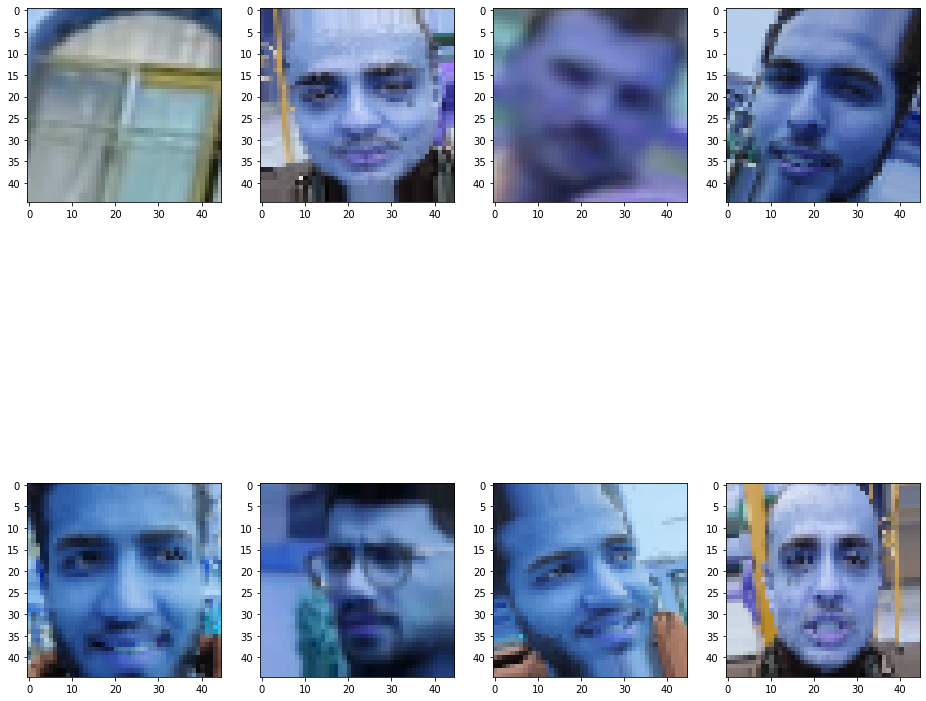

In [32]:
plt.figure(figsize=(16, 16))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0, 8):
        plt.subplot(2,4,i+1)
        plt.imshow(X_batch[i])
    # show the plot
    plt.show()
    break

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau 

In [34]:
optimizer_adam=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)

In [35]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
callback=[EarlyStop , Reduce_LR]

In [36]:
model=Sequential([
                  Conv2D(64,3,activation='relu',kernel_initializer='he_normal',input_shape=(48,48,3)),
                  MaxPooling2D(3),
                  Conv2D(128,3,activation='relu',kernel_initializer='he_normal'),
                  MaxPooling2D(3),
                  Flatten(),
                  Dense(128,activation='relu'),
                  Dense(5,activation='softmax',kernel_initializer='glorot_normal')
                  
])



model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])



history=model.fit(train_generator,validation_data=(X_train,y_train),epochs=3,
                  callbacks=callback, verbose=1,shuffle=True)

Epoch 1/3
143/143 [==============================] - 2s 15ms/step - loss: 1.0884 - accuracy: 0.5668 - val_loss: 52.8041 - val_accuracy: 0.8612
Epoch 2/3
143/143 [==============================] - 2s 14ms/step - loss: 0.3390 - accuracy: 0.8981 - val_loss: 18.0757 - val_accuracy: 0.9464
Epoch 3/3
143/143 [==============================] - 2s 14ms/step - loss: 0.1887 - accuracy: 0.9438 - val_loss: 39.2199 - val_accuracy: 0.8471


In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6

In [38]:
model.summary()
model.save('elsoudy.h5')

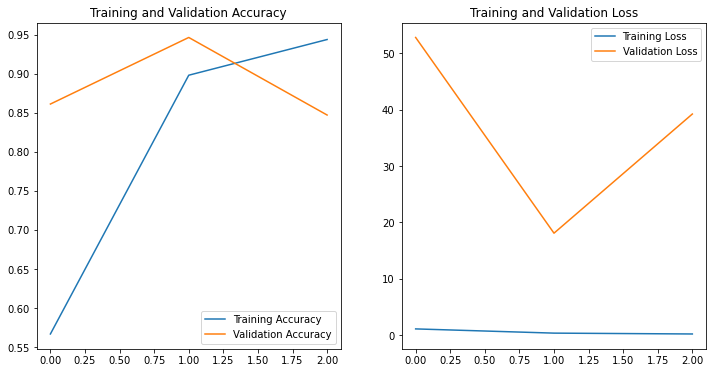

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=3
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
predictions = model.predict(X_train)

import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, predictions.argmax(axis=1))
cm

array([[257,  27,   1,   1,   0],
       [  0, 247,   0,   1,   0],
       [  2,  14,  54,  30,   0],
       [  1,  25,   0, 259,   0],
       [  3,   2,   1,  66, 147]], dtype=int64)

<AxesSubplot:>

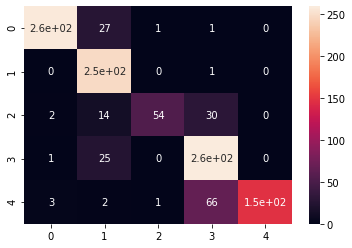

In [41]:
sns.heatmap(cm, annot=True)